In [ ]:
link = 'https://www.pse.pl/dane-systemowe/funkcjonowanie-rb/raporty-dobowe-z-funkcjonowania-rb/podstawowe-wskazniki-cenowe-i-kosztowe/rynkowa-cena-energii-elektrycznej-rce'
params_sel = 'span[class=nav-item-label]'
date_input_sel = 'input[name=data]'
confirm_sel = 'button[class*=apply]'
table_sel = 'tbody[id*=yui_patched]'

In [ ]:
import contextlib
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.remote.webelement import WebElement
from selenium.common.exceptions import TimeoutException, NoSuchWindowException
from typing import Union
from bs4 import BeautifulSoup as Bs
import pandas as pd
from datetime import datetime, timedelta
from app.data_managers.readers.driver_factory import DriverFactory
import time


class LimitExceededException(Exception):
    def __init__(self, date: str, *args: object) -> None:
        mes = f'limit exceeded at {date}'
        super().__init__(mes, *args)


DATE = 'Date'
PRICE = 'Price'
HOUR = 'Hour'
TIMEOUT = 10
WAIT = 0.3

def set_driver(headless: bool = True, driver = None):
    if driver is None:
        driver = DriverFactory.get_driver(headless=headless)    
    driver.get(link)
    return driver

def read_table(table_html: Bs) -> pd.DataFrame:
    df = pd.read_html(table_html)[0]
    converters = {df.columns[1]: lambda x: str(x.replace(u'\xa0', u''))}
    df = pd.read_html(table_html,
                      converters=converters,
                      decimal=',',
                      thousands='.')[0].dropna()
    df.columns = [HOUR, PRICE]
    return df

def transform_table(data: pd.DataFrame, date: str) -> pd.DataFrame:
    df = data.copy()
    df[PRICE] = pd.to_numeric(df[PRICE])
    df[DATE] = df[HOUR].apply(lambda x: date + timedelta(hours=x))
    df = df.drop(columns=HOUR)
    return df

def get_element(driver, selector: str, timeout: Union[int, float] = TIMEOUT) -> WebElement:
    element = WebDriverWait(driver=driver,
                            timeout=timeout).until(
    EC.element_to_be_clickable((By.CSS_SELECTOR, selector)))
    return element


def scrap_prices(dates: pd.DatetimeIndex, headless: bool = True):
    driver = set_driver(headless=headless)
    prices = pd.DataFrame()
    with contextlib.suppress(
        ValueError,
        TimeoutException,
        NoSuchWindowException,
        KeyboardInterrupt
    ):
        for date in dates:
            day_df = get_prices(date=date, driver=driver)
            prices = pd.concat([prices, day_df], ignore_index=True)
            
    prices = prices[[DATE, PRICE]].sort_values(DATE)
    return prices

def click_params(driver):
    params = get_element(driver=driver, selector=params_sel)
    params.click()
    time.sleep(WAIT)
    
def send_keys(driver, date: str):
    date_input = get_element(driver=driver, selector=date_input_sel)
    date_input.clear()
    date_input.send_keys(datetime.strftime(date, '%Y-%m-%d'))
    
def confirm(driver):
    confirm = get_element(driver=driver, selector=confirm_sel)
    confirm.click()
    time.sleep(WAIT)

def get_table_html(driver) -> str:
    table = get_element(driver=driver, selector=table_sel)
    table_html = table.get_attribute('innerHTML')
    return table_html
    
def get_prices(date: datetime, driver) -> pd.DataFrame:
    time.sleep(WAIT)
    click_params(driver=driver)
    send_keys(driver=driver, date=date)
    confirm(driver=driver)
    table_html = get_table_html(driver=driver)
    df = read_table(table_html=table_html)
    df = transform_table(data=df, date=date)
    return df
    
now = datetime.now()
r = pd.date_range('2023-01-01', now)
pr = scrap_prices(dates=r, headless=False)

In [ ]:
pr

In [ ]:
driver = DriverFactory.get_driver(headless=False) 
driver.get(link)

In [ ]:
def get_element(driver, selector: str, timeout: Union[int, float] = TIMEOUT) -> WebElement:
    element = WebDriverWait(driver=driver,
                            timeout=timeout).until(
    EC.visibility_of_any_elements_located((By.CSS_SELECTOR, selector)))
    return element

get_element(driver, 'span[class=nav-item-label]')[-1].click()

In [ ]:
from_, to = get_element(driver, 'input[id*=_VisioToolbar')

In [ ]:
from_.clear()
from_.send_keys('2022-12-01')
to.clear()
to.send_keys('2022-12-10')

In [ ]:
get_element(driver, 'button[class*=ui-datepicker-close]')[0].click()

In [ ]:
confirm = get_element(driver, "a[title='Eksport do CSV']")[-1].click()

In [ ]:
pr.set_index(DATE).plot()

In [ ]:
import contextlib
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.remote.webelement import WebElement
from selenium.common.exceptions import TimeoutException, NoSuchWindowException, NoSuchElementException
from typing import Union
from bs4 import BeautifulSoup as Bs
import pandas as pd
from datetime import datetime, timedelta
from driver_factory import DriverFactory
import time
import requests

main_page = 'https://www.pogodajutro.com/europe/poland?page=past-weather'


def set_up(headless: bool = True):
    driver = DriverFactory.get_driver(headless=headless)    
    driver.get(main_page)
    time.sleep(2)
    consent = driver.find_element(By.CSS_SELECTOR, "button[class='fc-button fc-cta-consent fc-primary-button']")
    consent.click()
    time.sleep(1)
    return driver

def build_df(driver, dates):
    weather = pd.DataFrame()
    for date in dates:
        print(date)
        link = f'{main_page}#day={date.day}&month={date.month}'
        driver.get(link)
        for year in (2019, 2020, 2021, 2022):
            try:
                time.sleep(1)
                year_tab = driver.find_element(By.CSS_SELECTOR, f"button[data-year='{year}']")
                driver.execute_script("arguments[0].click();", year_tab)
            except NoSuchElementException:
                print(f'No data for {year} {date.month} {date.day}')
                print(link)
                continue
            html = driver.page_source
            df = pd.read_html(html)[2]
            xd = pd.melt(df, id_vars=['Unnamed: 0'], var_name='Hour')
            xd = pd.pivot(xd, index='Hour', columns='Unnamed: 0', values='value').reset_index()
            xd['Year'] = year
            xd['Month'] = date.month
            xd['Day'] = date.day
            xd['Time'] = pd.to_datetime(xd[['Year', 'Month', 'Day', 'Hour']].astype(str).agg('-'.join, axis=1))
            xd = xd.drop(columns=['Year', 'Month', 'Day', 'Hour'])
            weather = pd.concat([weather, xd], ignore_index=True)
    return weather

driver = set_up(headless=True)
dates = pd.date_range('01-01-2012', '01-05-2012', freq='D')
# assert len(dates) == 366
df = build_df(driver, dates)


In [9]:
import pandas as pd

co = pd.read_excel(
    "data/CO2/PL_CENY_ROZL_CO2_20180101_20230516143458.xlsx",
    # skiprows=1,
    # index_col=0,
    # parse_dates=[0]
)
# co.columns = ["VALUE"]
co

c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Data,RCCO2,Unnamed: 2
0,NaN,[zł/Mg CO2],[EUR/Mg CO2]
1,2018-01-01,34.05,8.16
2,2018-01-02,32.5,7.79
3,2018-01-03,32.58,7.82
4,2018-01-04,32.21,7.76
...,...,...,...
1957,2023-05-11,396.26,87.55
1958,2023-05-12,398.55,87.7
1959,2023-05-13,399.17,87.84
1960,2023-05-14,397.99,87.58


In [7]:
pd.to_datetime(co.iloc[:, 0], format="%Y-%m-%d %H")

0      2018-01-01
1      2018-01-02
2      2018-01-03
3      2018-01-04
4      2018-01-05
          ...    
1956   2023-05-11
1957   2023-05-12
1958   2023-05-13
1959   2023-05-14
1960   2023-05-15
Name: Unnamed: 0, Length: 1961, dtype: datetime64[ns]

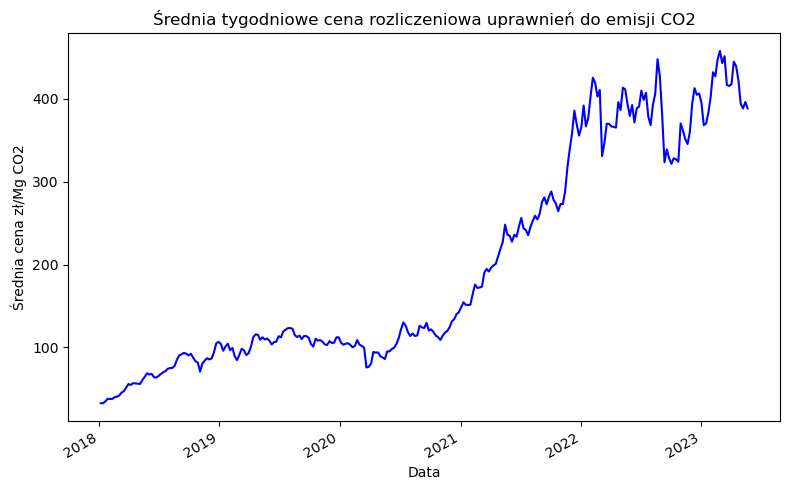

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(co.resample("W").mean(), color="blue")
plt.xticks(rotation=30, ha='right')
 
plt.title('Średnia tygodniowe cena rozliczeniowa uprawnień do emisji CO2')
 
plt.xlabel('Data')
plt.ylabel('Średnia cena zł/Mg CO2')
plt.tight_layout()


In [1]:
import zope

ModuleNotFoundError: No module named 'zope'

In [ ]:
from app.data_managers.readers import PSEReader

r = PSEReader("ENERGY_DEMAND")


In [ ]:
from os import listdir

directory = 'data/demand/'
files = listdir(directory)
files = list(map(lambda x: directory + x, files))

data = r.read(files)


In [ ]:
d = data["VALUE"]

In [ ]:
d = d.resample("H").sum(min_count=1).squeeze()

In [ ]:
from app.data_managers.uploaders import CSVUploader

CSVUploader("data/energy_demand.csv").upload(data)

In [ ]:
import pandas as pd

data = pd.read_csv("data/WEATHER.csv", parse_dates=["Time"], index_col="Time")

In [ ]:
g = data.resample("H").sum()

mask = g.isna().all(axis=1)
g.loc[mask]

In [ ]:
minn = data.index.min()
maxx = data.index.max()


print(len(data))
len(pd.date_range(minn, maxx, freq="H"))

In [ ]:
import requests

link = "https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2023-4-5"
response = requests.get(link)
html = response.text

In [ ]:
import pandas as pd

pd.read_html(html)

In [1]:
from datetime import datetime
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
import pandas as pd
from bs4 import BeautifulSoup as Bs
from app.data_managers.readers.scraping.driver_factory import DriverFactory
from selenium.common.exceptions import WebDriverException



sel = "table[aria-labelledby='History observation']"

def get_data(date: datetime, driver):
    str_date = date.strftime(r"%Y-%#m-%#d")
    link = f"https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/{str_date}"
    print(link)
    driver.get(link)
    
    element = WebDriverWait(
        driver=driver, timeout=5
    ).until(EC.visibility_of_element_located((By.CSS_SELECTOR, sel)))
    
    html = element.get_attribute("outerHTML")
    df = pd.read_html(html)[0].dropna(how="all")
    df["DATE"] = date
    return df

r = pd.date_range(pd.to_datetime("2021-09-27", dayfirst=True), datetime.now(), freq="D")
data = pd.DataFrame()
factory = DriverFactory(verbose=False)
driver = factory.get()

for date in r:
    try:
        df = get_data(date, driver)
    except WebDriverException as e:
        driver.quit()
        print(f"{date} failed {e}")
        driver = factory.get()
        continue
    except KeyboardInterrupt:
        break
    
    data = pd.concat((data, df), ignore_index=True)
        
driver.quit()

data

[WDM] - Downloading: 100%|██████████| 6.79M/6.79M [00:00<00:00, 11.9MB/s]


https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-9-27
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-9-28
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-9-29
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-9-30
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-10-1
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-10-2
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-10-3
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-10-4
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-10-5
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-10-6
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-10-7
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-10-8
https://www.wunderground.com/history/daily/pl/warsaw/EPWA/date/2021-10-9
https://www.wunderground.com/history/daily/pl/warsa

,Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition,DATE
0,12:00 AM,54 °F,50 °F,88 °%,E,5 °mph,0 °mph,29.83 °in,0.0 °in,Fair,2021-09-27
1,12:30 AM,54 °F,48 °F,82 °%,E,6 °mph,0 °mph,29.83 °in,0.0 °in,Fair,2021-09-27
2,1:00 AM,50 °F,48 °F,94 °%,E,5 °mph,0 °mph,29.83 °in,0.0 °in,Fair,2021-09-27
3,1:30 AM,50 °F,46 °F,87 °%,E,5 °mph,0 °mph,29.83 °in,0.0 °in,Fair,2021-09-27
4,2:00 AM,52 °F,48 °F,88 °%,E,9 °mph,0 °mph,29.83 °in,0.0 °in,Fair,2021-09-27
...,...,...,...,...,...,...,...,...,...,...,...
27035,1:30 PM,50 °F,48 °F,94 °%,SE,9 °mph,0 °mph,29.42 °in,0.0 °in,Light Rain,2023-04-15
27036,2:00 PM,52 °F,48 °F,88 °%,SE,8 °mph,0 °mph,29.42 °in,0.0 °in,Light Rain,2023-04-15
27037,2:30 PM,50 °F,48 °F,94 °%,ESE,8 °mph,0 °mph,29.42 °in,0.0 °in,Light Rain,2023-04-15
27038,3:00 PM,52 °F,48 °F,88 °%,ESE,8 °mph,0 °mph,29.42 °in,0.0 °in,Mostly Cloudy,2023-04-15


In [5]:
data.to_csv("ww_4.csv", index=False)

In [5]:
data.to_csv("ww.csv")

In [20]:
import pandas as pd

pd.read_csv("ww.csv").drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Time', 'DATE'])

,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition,DT
0,46,45,93,SSW,8,0,29.27,0.0,Mostly Cloudy,2018-01-01 01:00:00
1,46,45,93,SSW,9,0,29.27,0.0,Mostly Cloudy,2018-01-01 02:00:00
2,48,45,87,SSW,8,0,29.27,0.0,Mostly Cloudy,2018-01-01 03:00:00
3,48,43,82,SW,10,0,29.24,0.0,Mostly Cloudy,2018-01-01 04:00:00
4,46,43,87,SSW,10,0,29.24,0.0,Fair,2018-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...
56952,57 °F,48 °F,72 °%,E,10 °mph,0 °mph,29.77 °in,0.0 °in,Fair,NaN
56953,55 °F,48 °F,77 °%,E,10 °mph,0 °mph,29.80 °in,0.0 °in,Fair,NaN
56954,54 °F,46 °F,77 °%,E,9 °mph,0 °mph,29.80 °in,0.0 °in,Fair,NaN
56955,52 °F,46 °F,82 °%,E,9 °mph,0 °mph,29.80 °in,0.0 °in,Fair,NaN


In [1]:
import pandas as pd

NUM = ['Temperature', 'Dew Point',	'Humidity',	'Wind Speed',	'Wind Gust', 	'Pressure',	'Precip.']

far = ['Temperature', 'Dew Point']
mph = ['Wind Speed', 'Wind Gust']
inch = ['Pressure',	'Precip.']

def to_celcius(o: float, dec: int = 0) -> float:
    num = ((o - 32) * 5) / 9
    return round(num, dec)

def to_kmh(o: float, dec: int = 0) -> float:
    num = o * 1.609344
    return round(num, dec)

def to_cm(o: float, dec: int = 0) -> float:
    num = o * 2.54
    return round(num, dec)

def format_df(data: pd.DataFrame):
    df = data.copy()
    garbage = [col for col in df.columns if 'Unnamed' in col]
    df = df.drop(columns=garbage)
    replace = ["°F", "°%", "°mph", "°in", r'\xa0']
    replace_dict = {repl: "" for repl in replace}
    df = df.replace(replace_dict, regex=True)
    half = df["Time"].str.endswith("30 AM")
    df = df.loc[~half]
    half = df["Time"].str.endswith("30 PM")
    df = df.loc[~half]

    date = df["DATE"] + " " + df["Time"]
    df["DT"] = pd.to_datetime(date)
    df[NUM] = df[NUM].apply(pd.to_numeric)
    
    df = df.set_index("DT").resample("H").sum().sort_index()
    df[far] = df[far].applymap(to_celcius)
    df[mph] = df[mph].applymap(to_kmh)
    df[inch] = df[inch].applymap(to_cm)
    return df
    

In [1]:
files = ["ww.csv", "ww_2.csv", "ww_3.csv", "ww_4.csv"]

# f = [format_df(pd.read_csv(file)) for file in files]
# df = pd.concat(f)
from app.data_managers.readers import WeatherReader

w = WeatherReader("WEATHER")
# w.read(files)

In [3]:
df = w.read(files)


Index(['Unnamed: 0.1', 'Time', 'Temperature', 'Dew Point', 'Humidity', 'Wind',
       'Wind_Speed', 'Wind Gust', 'Pressure', 'Precip.', 'Condition', 'DATE',
       'DT', 'Unnamed: 0'],
      dtype='object')


In [6]:
df.to_csv("data/WEATHER_TEST.csv")

In [3]:
df = df[~df.index.duplicated()]
df

,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Precip.
DT,,,,,,,
2018-01-01 00:00:00,4.0,2.0,87,11.0,0.0,74.0,0.0
2018-01-01 01:00:00,8.0,7.0,93,13.0,0.0,74.0,0.0
2018-01-01 02:00:00,8.0,7.0,93,14.0,0.0,74.0,0.0
2018-01-01 03:00:00,9.0,7.0,87,13.0,0.0,74.0,0.0
2018-01-01 04:00:00,9.0,6.0,82,16.0,0.0,74.0,0.0
...,...,...,...,...,...,...,...
2023-04-15 11:00:00,9.0,8.0,93,21.0,0.0,75.0,0.0
2023-04-15 12:00:00,10.0,9.0,94,21.0,0.0,75.0,0.0
2023-04-15 13:00:00,11.0,9.0,88,23.0,0.0,75.0,0.0


In [67]:
df.to_csv("WEATHER_TEST.csv")

In [7]:

import pandas as pd

df = pd.read_csv("weather.csv").iloc[: , 1:]
df

,Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition
0,1:00 AM,46 °F,45 °F,93 °%,SSW,8 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
1,1:30 AM,46 °F,45 °F,93 °%,SSW,7 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
2,2:00 AM,46 °F,45 °F,93 °%,SSW,9 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
3,2:30 AM,48 °F,45 °F,87 °%,SSW,8 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
4,3:00 AM,48 °F,45 °F,87 °%,SSW,8 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
...,...,...,...,...,...,...,...,...,...,...
92098,9:30 PM,54 °F,46 °F,77 °%,NNE,6 °mph,0 °mph,29.86 °in,0.0 °in,Fair
92099,10:00 PM,54 °F,45 °F,72 °%,NNE,7 °mph,0 °mph,29.86 °in,0.0 °in,Fair
92100,10:30 PM,54 °F,45 °F,72 °%,N,6 °mph,0 °mph,29.86 °in,0.0 °in,Fair
92101,11:00 PM,52 °F,45 °F,76 °%,N,5 °mph,0 °mph,29.86 °in,0.0 °in,Fair


In [16]:
df.replace(["°F", "PM"], "", regex=True)

,Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition
0,1:00 AM,46,45,93 °%,SSW,8 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
1,1:30 AM,46,45,93 °%,SSW,7 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
2,2:00 AM,46,45,93 °%,SSW,9 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
3,2:30 AM,48,45,87 °%,SSW,8 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
4,3:00 AM,48,45,87 °%,SSW,8 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
...,...,...,...,...,...,...,...,...,...,...
92098,9:30,54,46,77 °%,NNE,6 °mph,0 °mph,29.86 °in,0.0 °in,Fair
92099,10:00,54,45,72 °%,NNE,7 °mph,0 °mph,29.86 °in,0.0 °in,Fair
92100,10:30,54,45,72 °%,N,6 °mph,0 °mph,29.86 °in,0.0 °in,Fair
92101,11:00,52,45,76 °%,N,5 °mph,0 °mph,29.86 °in,0.0 °in,Fair


In [14]:
x

'46\xa0'

In [37]:
df = pd.read_csv("ww.csv")
df = df.iloc[:, 2:]

In [26]:
def format_df(data: pd.DataFrame):
    df = data.copy()
    replace = ["°F", "°%", "°mph", "°in"]
    replace_dict = {repl: "" for repl in replace}
    df = df.replace(replace_dict, regex=True)
    half = df["Time"].str.endswith("30 AM")
    df = df.loc[~half]
    half = df["Time"].str.endswith("30 PM")
    df = df.loc[~half]

    date = df["DATE"] + " " + df["Time"]
    df["DT"] = pd.to_datetime(date)
    return df
    

In [24]:
df

,Unnamed: 0.1,Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition,DATE,DT,Unnamed: 0
0,0,1:00 AM,46,45,93,SSW,8,0,29.27,0.0,Mostly Cloudy,2018-01-01,2018-01-01 01:00:00,NaN
1,1,2:00 AM,46,45,93,SSW,9,0,29.27,0.0,Mostly Cloudy,2018-01-01,2018-01-01 02:00:00,NaN
2,2,3:00 AM,48,45,87,SSW,8,0,29.27,0.0,Mostly Cloudy,2018-01-01,2018-01-01 03:00:00,NaN
3,3,4:00 AM,48,43,82,SW,10,0,29.24,0.0,Mostly Cloudy,2018-01-01,2018-01-01 04:00:00,NaN
4,4,5:00 AM,46,43,87,SSW,10,0,29.24,0.0,Fair,2018-01-01,2018-01-01 05:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56952,39194,7:30 PM,57 °F,48 °F,72 °%,E,10 °mph,0 °mph,29.77 °in,0.0 °in,Fair,2021-09-27,NaN,39194.0
56953,39196,8:30 PM,55 °F,48 °F,77 °%,E,10 °mph,0 °mph,29.80 °in,0.0 °in,Fair,2021-09-27,NaN,39196.0
56954,39198,9:30 PM,54 °F,46 °F,77 °%,E,9 °mph,0 °mph,29.80 °in,0.0 °in,Fair,2021-09-27,NaN,39198.0
56955,39200,10:30 PM,52 °F,46 °F,82 °%,E,9 °mph,0 °mph,29.80 °in,0.0 °in,Fair,2021-09-27,NaN,39200.0


In [25]:
half = df["Time"].str.endswith("30 AM")
df = df.loc[~half]
half = df["Time"].str.endswith("30 PM")
df = df.loc[~half]

date = df["DATE"] + " " + df["Time"]
df["DT"] = pd.to_datetime(date)
df

,Unnamed: 0.1,Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition,DATE,DT,Unnamed: 0
0,0,1:00 AM,46,45,93,SSW,8,0,29.27,0.0,Mostly Cloudy,2018-01-01,2018-01-01 01:00:00,NaN
1,1,2:00 AM,46,45,93,SSW,9,0,29.27,0.0,Mostly Cloudy,2018-01-01,2018-01-01 02:00:00,NaN
2,2,3:00 AM,48,45,87,SSW,8,0,29.27,0.0,Mostly Cloudy,2018-01-01,2018-01-01 03:00:00,NaN
3,3,4:00 AM,48,43,82,SW,10,0,29.24,0.0,Mostly Cloudy,2018-01-01,2018-01-01 04:00:00,NaN
4,4,5:00 AM,46,43,87,SSW,10,0,29.24,0.0,Fair,2018-01-01,2018-01-01 05:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32680,32680,7:00 PM,59,48,67,E,10,0,29.77,0.0,Fair,2021-09-27,2021-09-27 19:00:00,NaN
32681,32681,8:00 PM,57,48,72,E,10,0,29.80,0.0,Fair,2021-09-27,2021-09-27 20:00:00,NaN
32682,32682,9:00 PM,55,48,77,E,9,0,29.80,0.0,Fair,2021-09-27,2021-09-27 21:00:00,NaN
32683,32683,10:00 PM,54,46,77,E,10,0,29.80,0.0,Fair,2021-09-27,2021-09-27 22:00:00,NaN


In [45]:
df.to_csv("ww.csv", index=False)


In [1]:
f = lambda x: x.replace(" ", "_")

f("ss rr")

'ss_rr'

In [7]:
df = pd.read_csv("weather.csv").iloc[:, 1:]
df

,Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition
0,1:00 AM,46 °F,45 °F,93 °%,SSW,8 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
1,1:30 AM,46 °F,45 °F,93 °%,SSW,7 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
2,2:00 AM,46 °F,45 °F,93 °%,SSW,9 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
3,2:30 AM,48 °F,45 °F,87 °%,SSW,8 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
4,3:00 AM,48 °F,45 °F,87 °%,SSW,8 °mph,0 °mph,29.27 °in,0.0 °in,Mostly Cloudy
...,...,...,...,...,...,...,...,...,...,...
92098,9:30 PM,54 °F,46 °F,77 °%,NNE,6 °mph,0 °mph,29.86 °in,0.0 °in,Fair
92099,10:00 PM,54 °F,45 °F,72 °%,NNE,7 °mph,0 °mph,29.86 °in,0.0 °in,Fair
92100,10:30 PM,54 °F,45 °F,72 °%,N,6 °mph,0 °mph,29.86 °in,0.0 °in,Fair
92101,11:00 PM,52 °F,45 °F,76 °%,N,5 °mph,0 °mph,29.86 °in,0.0 °in,Fair


In [26]:
import pytz

timezone = pytz.timezone('Poland')

r = pd.date_range(pd.to_datetime("01-01-2018 01:00:00", dayfirst=True), periods=len(df), freq="H", tz=timezone)

In [37]:
r[-250:-200]

DatetimeIndex(['2023-03-24 11:00:00+01:00', '2023-03-24 12:00:00+01:00',
               '2023-03-24 13:00:00+01:00', '2023-03-24 14:00:00+01:00',
               '2023-03-24 15:00:00+01:00', '2023-03-24 16:00:00+01:00',
               '2023-03-24 17:00:00+01:00', '2023-03-24 18:00:00+01:00',
               '2023-03-24 19:00:00+01:00', '2023-03-24 20:00:00+01:00',
               '2023-03-24 21:00:00+01:00', '2023-03-24 22:00:00+01:00',
               '2023-03-24 23:00:00+01:00', '2023-03-25 00:00:00+01:00',
               '2023-03-25 01:00:00+01:00', '2023-03-25 02:00:00+01:00',
               '2023-03-25 03:00:00+01:00', '2023-03-25 04:00:00+01:00',
               '2023-03-25 05:00:00+01:00', '2023-03-25 06:00:00+01:00',
               '2023-03-25 07:00:00+01:00', '2023-03-25 08:00:00+01:00',
               '2023-03-25 09:00:00+01:00', '2023-03-25 10:00:00+01:00',
               '2023-03-25 11:00:00+01:00', '2023-03-25 12:00:00+01:00',
               '2023-03-25 13:00:00+01:00', '2023-0